This notebook investigates Shapley Values proposed for tree based ensembles in [Consistent Individualized Feature Attribution for TreeEnsembles](https://arxiv.org/pdf/1802.03888.pdf).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-dataset" data-toc-modified-id="Create-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create dataset</a></span></li><li><span><a href="#XGBoost-models" data-toc-modified-id="XGBoost-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost models</a></span><ul class="toc-item"><li><span><a href="#Model-A" data-toc-modified-id="Model-A-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model A</a></span><ul class="toc-item"><li><span><a href="#Set-up-data" data-toc-modified-id="Set-up-data-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Set up data</a></span></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Check-predictions" data-toc-modified-id="Check-predictions-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Check predictions</a></span></li><li><span><a href="#Tree-structure" data-toc-modified-id="Tree-structure-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Tree structure</a></span></li><li><span><a href="#Calculate-prediction-contribution" data-toc-modified-id="Calculate-prediction-contribution-2.1.5"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Calculate prediction contribution</a></span></li></ul></li><li><span><a href="#Model-B" data-toc-modified-id="Model-B-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model B</a></span><ul class="toc-item"><li><span><a href="#Set-up-data" data-toc-modified-id="Set-up-data-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Set up data</a></span></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Check-predictions" data-toc-modified-id="Check-predictions-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Check predictions</a></span></li><li><span><a href="#Tree-structure" data-toc-modified-id="Tree-structure-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Tree structure</a></span></li><li><span><a href="#Calculate-prediction-contribution" data-toc-modified-id="Calculate-prediction-contribution-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Calculate prediction contribution</a></span></li></ul></li><li><span><a href="#Comment" data-toc-modified-id="Comment-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Comment</a></span></li></ul></li><li><span><a href="#Sklean-decision-trees" data-toc-modified-id="Sklean-decision-trees-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sklean decision trees</a></span><ul class="toc-item"><li><span><a href="#Model-A" data-toc-modified-id="Model-A-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model A</a></span><ul class="toc-item"><li><span><a href="#MAE" data-toc-modified-id="MAE-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>MAE</a></span></li><li><span><a href="#MSE" data-toc-modified-id="MSE-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>MSE</a></span></li></ul></li><li><span><a href="#Model-B" data-toc-modified-id="Model-B-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model B</a></span><ul class="toc-item"><li><span><a href="#MAE" data-toc-modified-id="MAE-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>MAE</a></span></li><li><span><a href="#MSE" data-toc-modified-id="MSE-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>MSE</a></span></li></ul></li><li><span><a href="#Comment" data-toc-modified-id="Comment-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comment</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import xgboost as xgb
import pygbmexpl as pygbmexpl
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Create dataset

In [2]:
data = pd.DataFrame(
    {
        'response_a':[80,0,0,0],
        'response_b':[90,10,0,0],
        'fever':[1,0,1,0], 
        'cough':[1,1,0,0]
    }
)

In [3]:
data

,response_a,response_b,fever,cough
0,80,90,1,1
1,0,10,0,1
2,0,0,1,0
3,0,0,0,0


# XGBoost models

Define params s.t. we have 'vanilla' trees - no regularisation, no scaling of learning rate.

In [4]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 2, 
    'subsample': 1,
    'colsample_bytree': 1,
    'eta': 1, 
    'lambda': 0,
    'gamma': 0,
    'alpha': 0
}

## Model A

### Set up data

In [5]:
data_xgb_a = xgb.DMatrix(data[['fever', 'cough']], label = data[['response_a']])
data_xgb_a.set_base_margin([0] * data.shape[0])

### Build model

In [6]:
xgb_model_a = xgb.train(
    params = params, 
    dtrain = data_xgb_a, 
    num_boost_round = 1
)

### Check predictions

In [7]:
xgb_model_a.predict(data_xgb_a)

array([80.,  0.,  0.,  0.], dtype=float32)

### Tree structure

In [8]:
xgb_model_a_df = pygbmexpl.xgb.parser.extract_model_predictions(xgb_model_a)
xgb_model_a_df

,tree,nodeid,depth,yes,no,missing,split,split_condition,leaf,gain,cover,node_type,H,G,weight
0,0,0,0,1.0,2.0,1.0,fever,1.0,NaN,1600.0,4,internal,4,-80.0,20.0
1,0,1,1,NaN,NaN,NaN,NaN,NaN,-0.0,NaN,2,leaf,2,0.0,-0.0
2,0,2,1,3.0,4.0,3.0,cough,1.0,NaN,3200.0,2,internal,2,-80.0,40.0
3,0,3,2,NaN,NaN,NaN,NaN,NaN,-0.0,NaN,1,leaf,1,0.0,-0.0
4,0,4,2,NaN,NaN,NaN,NaN,NaN,80.0,NaN,1,leaf,1,-80.0,80.0


### Calculate prediction contribution
Using Saabas method

In [9]:
pygbmexpl.xgb.explainer.decompose_prediction(xgb_model_a_df, data.iloc[0])

,tree,nodeid,yes,no,missing,split,split_condition,cover,weight,node_type,H,G,value,contributing_var,contribution
0,0,0,1.0,2.0,1.0,fever,1.0,4,20.0,internal,4,-80.0,1.0,base,20.0
2,0,2,3.0,4.0,3.0,cough,1.0,2,40.0,internal,2,-80.0,1.0,fever,20.0
4,0,4,NaN,NaN,NaN,NaN,NaN,1,80.0,leaf,1,-80.0,NaN,cough,40.0


## Model B

### Set up data

In [10]:
data_xgb_b = xgb.DMatrix(data[['fever', 'cough']], label = data[['response_b']])
data_xgb_b.set_base_margin([0] * data.shape[0])

### Build model

In [11]:
xgb_model_b = xgb.train(
    params = params, 
    dtrain = data_xgb_b, 
    num_boost_round = 1
)

### Check predictions

In [12]:
xgb_model_b.predict(data_xgb_b)

array([90., 10.,  0.,  0.], dtype=float32)

### Tree structure

In [13]:
xgb_model_b_df = pygbmexpl.xgb.parser.extract_model_predictions(xgb_model_b)
xgb_model_b_df

,tree,nodeid,depth,yes,no,missing,split,split_condition,leaf,gain,cover,node_type,H,G,weight
0,0,0,0,1.0,2.0,1.0,cough,1.0,NaN,2500.0,4,internal,4,-100.0,25.0
1,0,1,1,NaN,NaN,NaN,NaN,NaN,-0.0,NaN,2,leaf,2,0.0,-0.0
2,0,2,1,3.0,4.0,3.0,fever,1.0,NaN,3200.0,2,internal,2,-100.0,50.0
3,0,3,2,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1,leaf,1,-10.0,10.0
4,0,4,2,NaN,NaN,NaN,NaN,NaN,90.0,NaN,1,leaf,1,-90.0,90.0


### Calculate prediction contribution
Using Saabas method

In [14]:
pygbmexpl.xgb.explainer.decompose_prediction(xgb_model_b_df, data.iloc[0])

,tree,nodeid,yes,no,missing,split,split_condition,cover,weight,node_type,H,G,value,contributing_var,contribution
0,0,0,1.0,2.0,1.0,cough,1.0,4,25.0,internal,4,-100.0,1.0,base,25.0
2,0,2,3.0,4.0,3.0,fever,1.0,2,50.0,internal,2,-100.0,1.0,cough,25.0
4,0,4,NaN,NaN,NaN,NaN,NaN,1,90.0,leaf,1,-90.0,NaN,fever,40.0


## Comment

We have reproduced the results presented in Figure 1 of [Consistent Individualized Feature Attribution for TreeEnsembles](https://arxiv.org/pdf/1802.03888.pdf). <br>
As we can see Model A attributes more importance to `cough` and Model B attributes more to `fever`. <br>
However Model A can be written as `output = [cough & fever]*80` and Model B can be written as `output = [cough & fever]*80 + [cough]*10` so 'cough' should be more important in Model B. <br>
We can also see that some of the contribution that would otherwise be attributed to the first split in each model, is attributed to the `base`. This is the starting point for each tree, here it is the average of the response as we're using squared error loss function.

# Sklean decision trees

Note, if we used a different loss function (e.g. mean absolute error) then the base value i.e. the prediction for the root note would be different. <br>
We cannot use MAE as a loss function in xgboost as it requires derivates of the loss function which is not defined at x = 0 for MAE - however we can use the decision tree regressor from scikit-learn.

In [15]:
tree_model_mae = DecisionTreeRegressor(
    criterion = 'mae', 
    max_depth = 2, 
    min_samples_leaf = 1, 
    min_samples_split = 2, 
    random_state = 100
)

In [21]:
tree_model_mse = DecisionTreeRegressor(
    criterion = 'mse', 
    max_depth = 2, 
    min_samples_leaf = 1, 
    min_samples_split = 2, 
    random_state = 100
)

## Model A

### MAE

In [16]:
tree_mae_model_a = tree_model_mae.fit(X = data[['fever', 'cough']], y = data[['response_a']])

[Text(133.92000000000002, 181.2, 'X[0] <= 0.5\nmae = 20.0\nsamples = 4\nvalue = 0.0'),
 Text(66.96000000000001, 108.72, 'mae = 0.0\nsamples = 2\nvalue = 0.0'),
 Text(200.88000000000002, 108.72, 'X[1] <= 0.5\nmae = 40.0\nsamples = 2\nvalue = 40.0'),
 Text(133.92000000000002, 36.23999999999998, 'mae = 0.0\nsamples = 1\nvalue = 0.0'),
 Text(267.84000000000003, 36.23999999999998, 'mae = 0.0\nsamples = 1\nvalue = 80.0')]

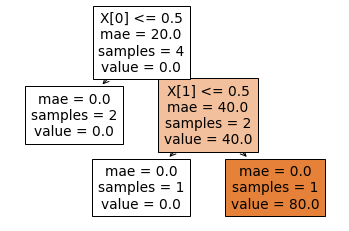

In [17]:
plot_tree(tree_mae_model_a, filled = True)

### MSE

In [22]:
tree_mse_model_a = tree_model_mse.fit(X = data[['fever', 'cough']], y = data[['response_a']])

[Text(133.92000000000002, 181.2, 'X[0] <= 0.5\nmse = 1200.0\nsamples = 4\nvalue = 20.0'),
 Text(66.96000000000001, 108.72, 'mse = 0.0\nsamples = 2\nvalue = 0.0'),
 Text(200.88000000000002, 108.72, 'X[1] <= 0.5\nmse = 1600.0\nsamples = 2\nvalue = 40.0'),
 Text(133.92000000000002, 36.23999999999998, 'mse = 0.0\nsamples = 1\nvalue = 0.0'),
 Text(267.84000000000003, 36.23999999999998, 'mse = 0.0\nsamples = 1\nvalue = 80.0')]

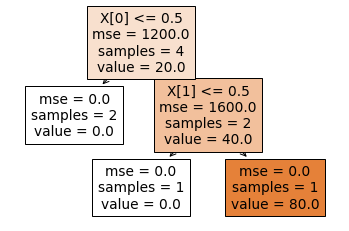

In [23]:
plot_tree(tree_mse_model_a, filled = True)

## Model B

### MAE

In [18]:
tree_mae_model_b = tree_model.fit(X = data[['fever', 'cough']], y = data[['response_b']])

[Text(133.92000000000002, 181.2, 'X[1] <= 0.5\nmae = 25.0\nsamples = 4\nvalue = 5.0'),
 Text(66.96000000000001, 108.72, 'mae = 0.0\nsamples = 2\nvalue = 0.0'),
 Text(200.88000000000002, 108.72, 'X[0] <= 0.5\nmae = 40.0\nsamples = 2\nvalue = 50.0'),
 Text(133.92000000000002, 36.23999999999998, 'mae = 0.0\nsamples = 1\nvalue = 10.0'),
 Text(267.84000000000003, 36.23999999999998, 'mae = 0.0\nsamples = 1\nvalue = 90.0')]

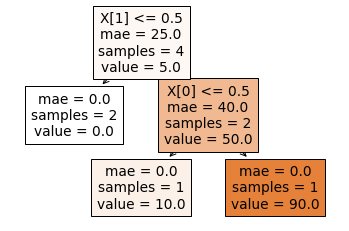

In [20]:
plot_tree(tree_mae_model_b, filled = True)

### MSE

In [24]:
tree_mse_model_b = tree_model_mse.fit(X = data[['fever', 'cough']], y = data[['response_b']])

[Text(133.92000000000002, 181.2, 'X[1] <= 0.5\nmse = 1425.0\nsamples = 4\nvalue = 25.0'),
 Text(66.96000000000001, 108.72, 'mse = 0.0\nsamples = 2\nvalue = 0.0'),
 Text(200.88000000000002, 108.72, 'X[0] <= 0.5\nmse = 1600.0\nsamples = 2\nvalue = 50.0'),
 Text(133.92000000000002, 36.23999999999998, 'mse = 0.0\nsamples = 1\nvalue = 10.0'),
 Text(267.84000000000003, 36.23999999999998, 'mse = 0.0\nsamples = 1\nvalue = 90.0')]

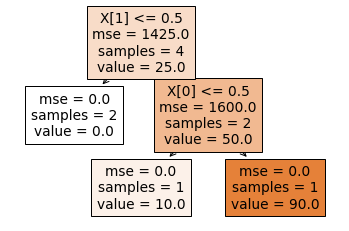

In [25]:
plot_tree(tree_mse_model_b, filled = True)

## Comment

Using the MSE loss function in the scikit-learn decision tree model we have produced the same tree as we did with xgboost. <br>
We can see that by changing the loss function we have changed the base value for the trees (i.e. the prediction for the root node) - but none of the other node predictions in the model.